#Functions


In [3]:

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pickle
import random
import datetime
from sklearn.preprocessing    import StandardScaler 
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn                  import metrics
from sklearn.experimental import enable_iterative_imputer
#
import joblib
from catboost import CatBoostClassifier
import json
import sqlite3
#Reads and construct the dataframe from the last version of trips.csv
def data_input():
    df=pd.read_csv("trips.csv")
    #Replace patterns to obtain only the coordinates
    df=df.replace("POINT ", "", regex=True)
    df=df.replace('', '_', regex=True)
    df['origin_coord']=df['origin_coord'].str.replace(r"(","")
    df['origin_coord']=df['origin_coord'].str.replace(r")","")
    df['destination_coord']=df['destination_coord'].str.replace(r"(","")
    df['destination_coord']=df['destination_coord'].str.replace(r")","")
    origins=pd.DataFrame(columns=['x','y'])
    dest=pd.DataFrame(columns=['x','y'])
    df_origins = df.origin_coord.str.split(' ', expand=True)
    df_dest = df.destination_coord.str.split(' ', expand=True)
    origins["x"]=df_origins.iloc[:,0]
    origins["y"]=df_origins.iloc[:,1]
    dest["x"]=df_dest.iloc[:,0]
    dest["y"]=df_dest.iloc[:,1]
    #df_origins=pd.to_numeric(df_origins)
    #df_dest=pd.to_numeric(df_dest)
    origins["x"]=pd.to_numeric(origins["x"])
    origins["y"]=pd.to_numeric(origins["y"])
    dest["x"]=pd.to_numeric(dest["x"])
    dest["y"]=pd.to_numeric(dest["y"])
    df['Euclidian_Distance']=np.sqrt((origins.x-dest.x)**2+(origins.y-dest.y)**2)
    df["origin_x"]=origins.x
    df["origin_y"]=origins.y
    df["destination_x"]=dest.x
    df["destination_y"]=dest.y
    df=df.drop(['origin_coord','destination_coord'],axis=1)
    df['Hour_Of_Day']=pd.to_datetime(df['datetime'])
    df['Hour_Of_Day']=df['Hour_Of_Day'].dt.day
    df['Week_Of_Year']=pd.to_datetime(df['datetime'])
    df['Week_Of_Year']=df['Week_Of_Year'].dt.isocalendar().week
    return df
#Clustering Algorithm
def Trip_Clustering(df):
    X = np.array(df[["origin_x","origin_y","destination_x","destination_y","Hour_Of_Day","Euclidian_Distance"]])
    y = np.array(df['region'])
    Nc = range(1, 20)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    kmeans = KMeans(n_clusters=5).fit(X)
    centroids = kmeans.cluster_centers_
    # Predicting the clusters
    labels = kmeans.predict(X)
    # Getting the cluster centers
    C = kmeans.cluster_centers_
    #Labeling trips
    df['label'] = labels;
    return X,y

def Weekly_avg_Bounding_Box(df):
    #Now, let's define the dimensions of the bounding box
    #x Coordinate of the center
    x=float(input("Enter x coordinate of center:"))
    #y Coordinate of the center
    y=float(input("Enter y coordinate of center:"))
    #width of the bounding box
    w=float(input("Enter width of bounding box:"))
    #height of the bounding box
    h=float(input("Enter width of bounding box:"))
    #Now let's set the bounding box bounds
    left_bound=x-(w/2)
    right_bound=x+(w/2)
    upper_bound=y+(h/2)
    lower_bound=y-(h/2)
    #Now let's filter de dataframe by the bounds of the bounding box
    df = df[df['origin_x'] <= right_bound ]
    df = df[df['origin_x'] >= left_bound ]
    df = df[df['origin_y'] <= upper_bound ]
    df = df[df['origin_y'] >= lower_bound ]
    print(lower_bound,upper_bound,left_bound,right_bound)
    print(df)
    WK=df.groupby(['Week_Of_Year']).datetime.count()
    #We count by datetime stamp since is like an ID    
    WK.head()
    #We now can see the amount of trips by number of week of the year
    #Now we obtain the average for the dataframe 
    Weekly_Trips_Avg=WK.mean()
    print("The average weekly amount of trips for the bounding box is: ",Weekly_Trips_Avg, "trips")

    return Weekly_Trips_Avg

def Weekly_avg_region(df):
    WK=df.groupby(['region','Week_Of_Year']).datetime.count()  
    Weekly_Trips_Avg_by_region=WK.groupby(['region']).mean()
    #print("The average weekly amount of trips for each Region is: ",Weekly_Trips_Avg_by_region, "trips")
    print("Weekly Average trips by Region")
    print(Weekly_Trips_Avg_by_region)
    return Weekly_Trips_Avg_by_region

def pipeline_CatBoost(df):
    df=df.drop(['datetime'],axis=1)
    region_dict=dict(Hamburg=0,Prague=1,Turin=2)
    datasource_dict=dict(baba_car=0,funny_car=1,cheap_mobile=2,pt_search_app=3,bad_diesel_vehicles=4)
    df['region']=df['region'].map(region_dict)
    df['datasource']=df['datasource'].map(datasource_dict)
    X= df.values[:,0:-1]
    Y=df.values[:,-1]
    scaler= StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    Y=Y.astype(int)
    
    X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.20, random_state=10)
    model=CatBoostClassifier(iterations=1000,
                               task_type="CPU",
                               devices='0:1')
    
    model.fit(X_train,Y_train)
    Y_pred= model.predict(X_test)
    cfm_CBC=confusion_matrix(Y_test,Y_pred)
    print("Confusion Matrix: ")
    print(cfm_CBC)

    print("Classification report: ")

    print(classification_report(Y_test,Y_pred))

    acc_CBC=accuracy_score(Y_test, Y_pred)
    print("Accuracy of the model: ",acc_CBC)
    disp = ConfusionMatrixDisplay(confusion_matrix=cfm_CBC,display_labels=['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5'])
    print(disp.plot())
    print(plt.show())
    
    return model

def random_imputation():
    df=pd.read_csv('trips.csv')
    cols=['region','datetime','datasource','origin_x','origin_y','destination_x','destination_y','Hour_Of_Day','Week_Of_Year','Euclidian_Distance']
    random_df=pd.DataFrame(index=range(10000000),columns=cols)
    #random_df["datetime"]=datetime.datetime(2002, random.randint(1,12), random.randint(1,30),random.randint(0,23),random.randint(0,59))
    
    return random_df


In [3]:
%pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


# Only use the Code below if you are running this Jupyter Notebook on Google collab

Otherwise you can just run the data_input function

In [6]:
from google.colab import files
uploaded = files.upload()

Saving trips.csv to trips.csv


# Solution: 
Firts we call de data input function and then perform the clustering 

In [4]:

df=data_input()
x,y=Trip_Clustering(df)

   

<ipython-input-3-4b8929502819>:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['origin_coord']=df['origin_coord'].str.replace(r"(","")
<ipython-input-3-4b8929502819>:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['origin_coord']=df['origin_coord'].str.replace(r")","")
<ipython-input-3-4b8929502819>:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['destination_coord']=df['destination_coord'].str.replace(r"(","")
<ipython-input-3-4b8929502819>:29: FutureWarning: The default value of regex will change from Tr

Now we calculate the Weekly averages required
#Weekly Average by Region

In [5]:
Weekly_Trips_Avg_by_region=Weekly_avg_region(df)

Weekly Average trips by Region
region
Hamburg    5.6
Prague     6.8
Turin      7.6
Name: datetime, dtype: float64


#Weekly Average by defined Bounding Box 
Bounding must be define through a (x,y) center, w widht and h height.
The objective is to capture all the points within the box.

I interpreted the requirement as it says above. Maybe another way could be to save the initial scatter plot for the coordinates as a ONG, and then use OpenCV library to detect patterns/images and automatically detect a bounding box for a cluster. Didn't thought it was strictly necessary for this case.


In [6]:
Weekly_Trips_Avg=Weekly_avg_Bounding_Box(df)

Enter x coordinate of center:4
Enter y coordinate of center:20
Enter width of bounding box:50
Enter width of bounding box:50
-5.0 45.0 -21.0 29.0
   region             datetime           datasource  Euclidian_Distance  \
1   Turin  2018-05-21 02:54:04             baba_car            0.086368   
14  Turin  2018-05-25 15:16:35        pt_search_app            0.141371   
20  Turin  2018-05-16 11:56:33        pt_search_app            0.193820   
37  Turin  2018-05-26 12:14:42  bad_diesel_vehicles            0.126706   
56  Turin  2018-05-13 22:16:27        pt_search_app            0.096678   
63  Turin  2018-05-27 09:49:16         cheap_mobile            0.073031   
72  Turin  2018-05-11 05:58:34         cheap_mobile            0.192480   
76  Turin  2018-05-02 00:22:18        pt_search_app            0.026796   

    origin_x   origin_y  destination_x  destination_y  Hour_Of_Day  \
1   7.672838  44.995711       7.720369      45.067824           21   
14  7.557295  44.980984       7.634489

# Machine Learning Module
Obviously, is faster to predict with a supervised trained model to predict the label or cluster of a registered trip with all its keys/variables combinations.

Let's use the popular Classification Algorithm: CatBoost
Since has been proven to be suitable for this kind of classification.

The Machine Learning Pipeline has been defined in the "functions.py" file, we are just going to call it and explore the results.


Learning rate set to 0.069563
0:	learn: 1.5282047	total: 3.17ms	remaining: 3.17s
1:	learn: 1.4396257	total: 5.5ms	remaining: 2.75s
2:	learn: 1.3888809	total: 7.75ms	remaining: 2.58s
3:	learn: 1.3274536	total: 9.92ms	remaining: 2.47s
4:	learn: 1.2889449	total: 12.1ms	remaining: 2.42s
5:	learn: 1.2227203	total: 14.6ms	remaining: 2.42s
6:	learn: 1.1788046	total: 16.9ms	remaining: 2.39s
7:	learn: 1.1233496	total: 18.2ms	remaining: 2.26s
8:	learn: 1.0791269	total: 20.4ms	remaining: 2.24s
9:	learn: 1.0505869	total: 22.5ms	remaining: 2.22s
10:	learn: 1.0132717	total: 25.6ms	remaining: 2.3s
11:	learn: 0.9825895	total: 27.8ms	remaining: 2.29s
12:	learn: 0.9644291	total: 30.2ms	remaining: 2.29s
13:	learn: 0.9415888	total: 32.3ms	remaining: 2.27s
14:	learn: 0.9026587	total: 33.3ms	remaining: 2.18s
15:	learn: 0.8757891	total: 35.4ms	remaining: 2.18s
16:	learn: 0.8402461	total: 37.6ms	remaining: 2.17s
17:	learn: 0.8181052	total: 39.7ms	remaining: 2.17s
18:	learn: 0.7943360	total: 41.9ms	remaining: 

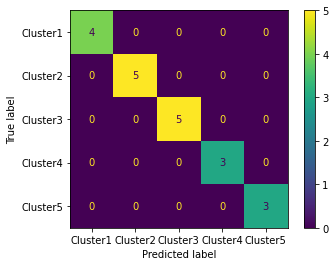

None


In [8]:
trained_model=pipeline_CatBoost(df)



# We can se that the precission, recall and f1-Score are near the 100%. this means CatBoost is a suitable Classification algorithm for this case. The confusion matrix show no scattering in the predictions:
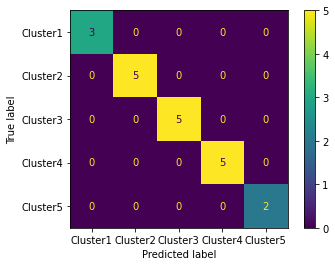

In [68]:
#Lets save our model to a pickle file
Pkl_Filename = "Pickle_Catboost_Model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(Pkl_Filename, file)

#Scalabilty


In [10]:

random_df=random_imputation()
df=random_df
df["region"]=random.randint(0,2)
df["datetime"]=datetime.datetime(2002, random.randint(1,12), random.randint(1,30),random.randint(0,23),random.randint(0,59))
df["origin_x"]=random.randint(0,100)
df["origin_y"]=random.randint(0,100)
df["destination_x"]=random.randint(0,100)
df["destination_y"]=random.randint(0,100)
df["datasource"]=random.randint(0,4)
df['Euclidian_Distance']=np.sqrt((df.origin_x-df.destination_x)**2+(df.origin_y-df.destination_y)**2)
df['Hour_Of_Day']=pd.to_datetime(df['datetime'])
df['Hour_Of_Day']=df['Hour_Of_Day'].dt.day
df['Week_Of_Year']=pd.to_datetime(df['datetime'])
df['Week_Of_Year']=df['Week_Of_Year'].dt.isocalendar().week
df=df.drop(['datetime'],axis=1)
X=df.values
scaler= StandardScaler()
scaler.fit(X)
df["Predicted_Label"]=trained_model.predict(X)


# Until Now, we can Random Input up to 10.000.000 of elements with no problem (My PC has 12 GB of RAM).

